In [70]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

import warnings
warnings.filterwarnings("ignore")

# ChAIR data overview

In [40]:
df = pd.read_csv("../data/data_ChAIR/single_cell/patski.dis.stat.txt", sep='\t')
df.head()

,cellid,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_ATAC,nFeature_ATAC,TSS.enrichment,TSS.percentile,...,singleG2M.Score,singlePhase,S.Score,G2M.Score,Phase,PC_1,PC_2,contact_number,distance,metacell
0,SCG0092_GCCTGCTGTGAGCGAA-1,SCG0092,2121,1524,6.748466,8.128834,5298,2620,1.873637,0.89,...,0.002406,G2M,-0.108243,-0.000510,G1,0.502462,2.418657,2574,8.086016,G1_0
1,SCG0090_TTCCTTGAGTAGCGGG-1,SCG0090,3913,2462,6.525535,4.714099,7197,3357,2.313965,0.93,...,-0.017008,G1,-0.071187,-0.015068,G1,1.180161,1.525348,2354,7.113897,G1_0
2,SCG0089_TCGTTATTCTGTAATG-1,SCG0089,2227,1621,6.056130,5.612999,2637,1296,2.348871,0.94,...,0.003201,G2M,-0.073382,-0.003418,G1,0.524131,2.148319,837,6.724441,G1_0
3,SCG0090_CTAGTGAGTATTTGGG-1,SCG0090,1877,1345,6.600518,7.722174,2518,1225,2.564103,0.95,...,-0.041638,G1,-0.098018,-0.043666,G1,-0.249158,2.768435,854,5.636900,G1_0
4,SCG0088_GTCTTGCTCAAACCGT-1,SCG0088,3034,2063,8.182064,5.147656,5662,2614,2.868243,0.97,...,-0.006544,G1,-0.120537,-0.007400,G1,0.676222,1.749475,1963,5.414676,G1_0


# Clustering of ChromMovie derived motifs

In [31]:
def read_cif(path):
    df = pd.DataFrame(columns=["chr", "x", "y", "z"])
    with open(path, 'r') as f:
        for line in f:
            if line.startswith("ATOM"):
                line_split = line.split()
                chrom = line_split[6]
                x, y, z = line_split[-3:]
                df.loc[df.shape[0]] = [chrom, x, y, z]
    return df

In [32]:
path = "../data/ChromMovie/test_099/frames_cif"
path_out = "../data/ChromMovie/test_099/frames_pd"
files = os.listdir(path)

In [36]:
for file in tqdm(files):
    if file.startswith("step099"):
        df = read_cif(os.path.join(path, file))
        df.to_csv(os.path.join(path_out, file.split(".")[0]+".csv"))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [06:00<00:00, 12.01s/it]


In [72]:
files_df = os.listdir(path_out)
files_df.sort()
dfs = [pd.read_csv(os.path.join(path_out, file), index_col=0) for file in files_df]

In [77]:
def get_kmers(dfs, length=200, width=5):
    n = len(dfs)
    kmers = []
    for i in tqdm(range(dfs[0].shape[0]-length)):
        chrom = dfs[0]["chr"].iloc[i]
        chrom_end = dfs[0]["chr"].iloc[i+length-1]
        if chrom == chrom_end:
            for df_id in range(n-width+1):
                sub_structures = []
                for j in range(width):
                    sub_structures.append(np.array(dfs[df_id+j][['x', 'y', 'z']].iloc[i:i+length,:]).flatten())
                kmers.append( np.hstack(sub_structures) )
    return np.vstack(kmers)

In [79]:
kmers = get_kmers(dfs)

100%|████████████████████████████████████████████████████████████████████████████| 26162/26162 [06:45<00:00, 64.58it/s]


In [80]:
kmers.shape

(220812, 3000)

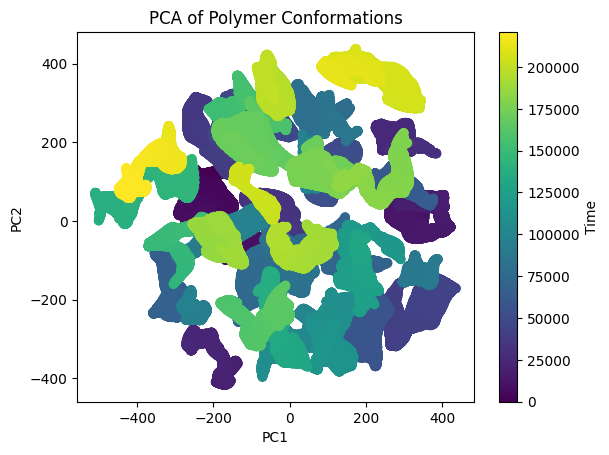

In [81]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(kmers)

plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=range(len(reduced_pca)), cmap='viridis')
plt.title('PCA of Polymer Conformations')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Time')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_tsne = tsne.fit_transform(kmers)

plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=range(len(reduced_tsne)), cmap='plasma')
plt.title('t-SNE of Polymer Conformations')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.colorbar(label='Time')
plt.show()

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
reduced_umap = reducer.fit_transform(kmers)

plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=range(len(reduced_umap)), cmap='cool')
plt.title('UMAP of Polymer Conformations')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Time')
plt.show()